In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import time

In [53]:
# Load dataset
df = pd.read_csv("creditcard.csv")
print(f"Dataset shape: {df.shape}")
print(f"Number of fraud cases: {df[df['Class'] == 1].shape[0]}")
print(f"Number of normal cases: {df[df['Class'] == 0].shape[0]}")

Dataset shape: (284807, 31)
Number of fraud cases: 492
Number of normal cases: 284315


In [54]:
# === Descriptive Statistics === #
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+

In [55]:
## 3. Data Preprocessing

### 3.1 Feature Scaling

'''* Scaled the `Amount` and `Time` features using `StandardScaler`
* Dropped original `Time` and `Amount` columns'''

'* Scaled the `Amount` and `Time` features using `StandardScaler`\n* Dropped original `Time` and `Amount` columns'

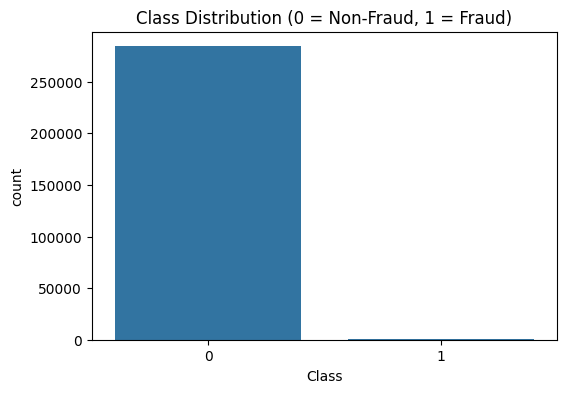

In [56]:
# === Class Distribution Visualization === #
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Class")
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.show()

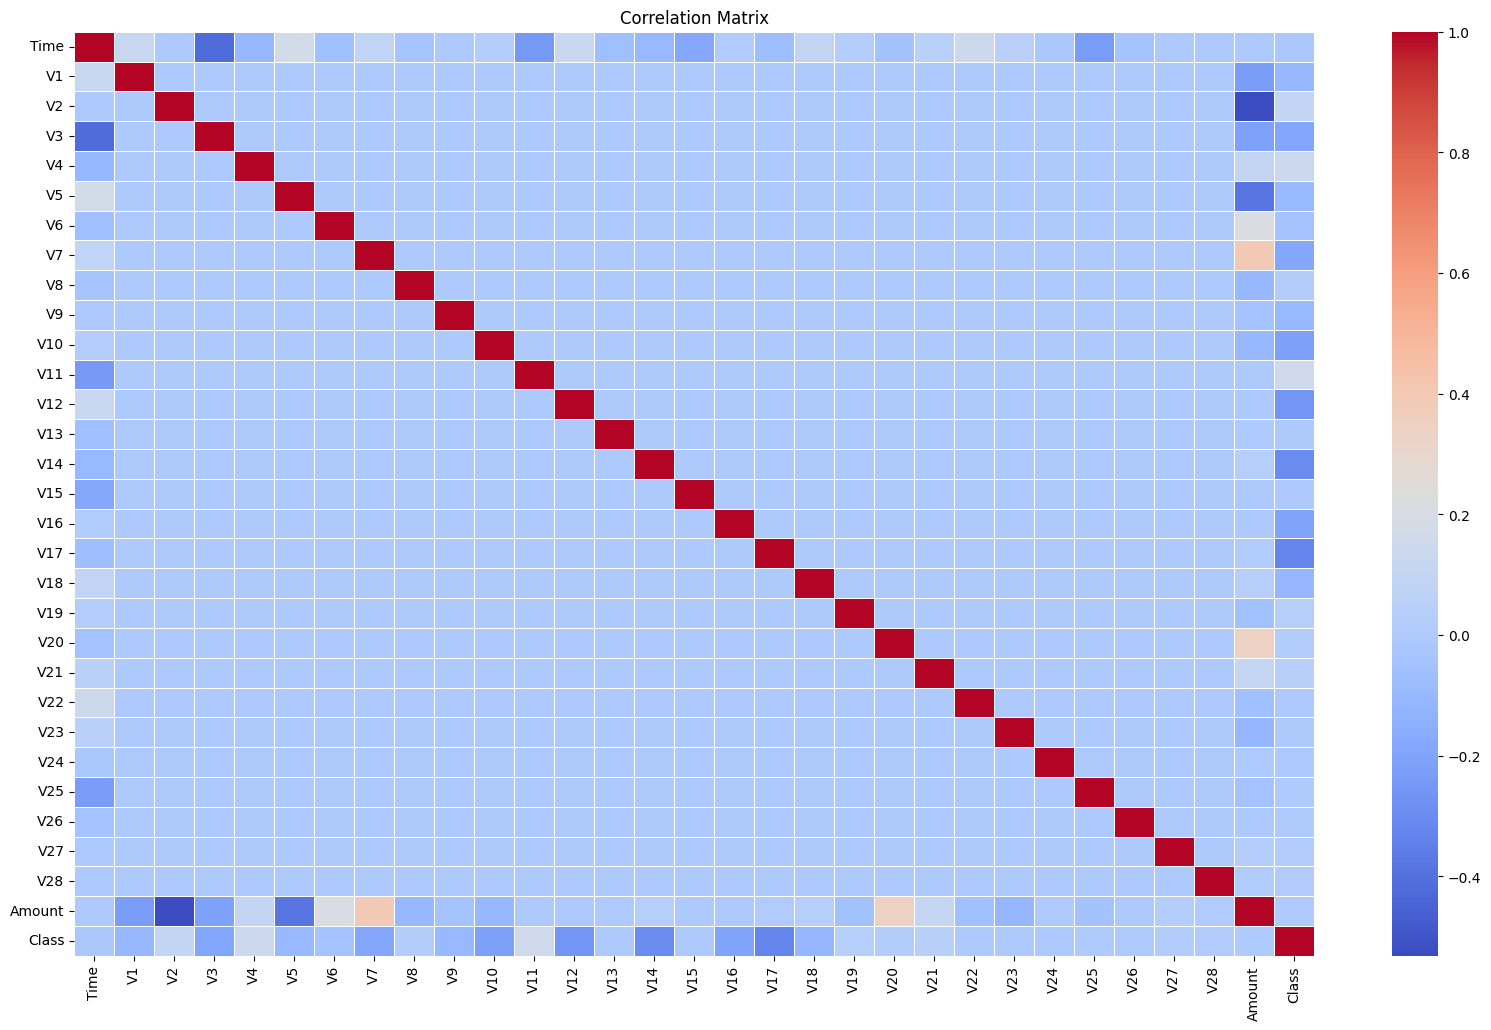

In [57]:
# === Correlation Matrix === #
plt.figure(figsize=(20, 12))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [58]:
# === Scale 'Time' and 'Amount' === #
scaler = StandardScaler()
df["scaled_amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["scaled_time"] = scaler.fit_transform(df["Time"].values.reshape(-1, 1))
df.drop(["Time", "Amount"], axis=1, inplace=True)

In [59]:
# Reorder columns
scaled_features = ["scaled_amount", "scaled_time"]
remaining_features = [col for col in df.columns if col not in scaled_features + ["Class"]]
df = df[scaled_features + remaining_features + ["Class"]]

In [60]:
# === Train-test split === #
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [61]:
# === Apply SMOTE === #
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
print(f"After SMOTE - Class 0: {sum(y_resampled == 0)}, Class 1: {sum(y_resampled == 1)}")


After SMOTE - Class 0: 227451, Class 1: 227451


In [62]:
# === Train Random Forest === #
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
start_time = time.time()
clf.fit(X_resampled, y_resampled)
end_time = time.time()
print(f"\n✅ Model trained in {end_time - start_time:.2f} seconds.")


✅ Model trained in 64.88 seconds.


In [63]:
# === Predictions === #
y_pred = clf.predict(X_test)

Unique predictions: [0 1]


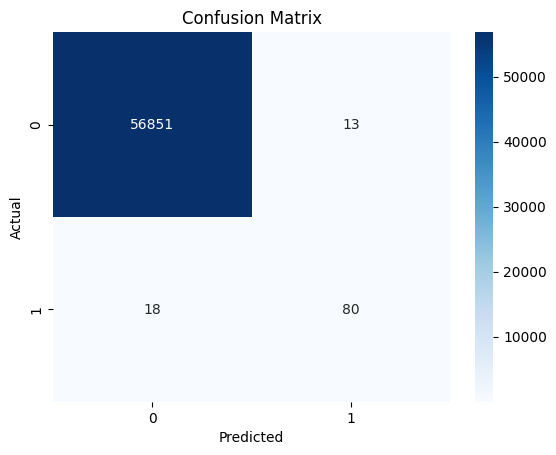

In [64]:
# === Confusion Matrix === #
print("Unique predictions:", np.unique(y_pred))
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [65]:
# === Classification Report === #
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8602    0.8163    0.8377        98

    accuracy                         0.9995     56962
   macro avg     0.9299    0.9080    0.9187     56962
weighted avg     0.9994    0.9995    0.9994     56962



In [66]:
# === ROC-AUC Score === #
probas = clf.predict_proba(X_test)
if probas.shape[1] == 2:
    auc_score = roc_auc_score(y_test, probas[:, 1])
    print(f"ROC-AUC Score: {auc_score:.4f}")
else:
    print("ROC-AUC Score: Model predicted only one class.")

ROC-AUC Score: 0.9791


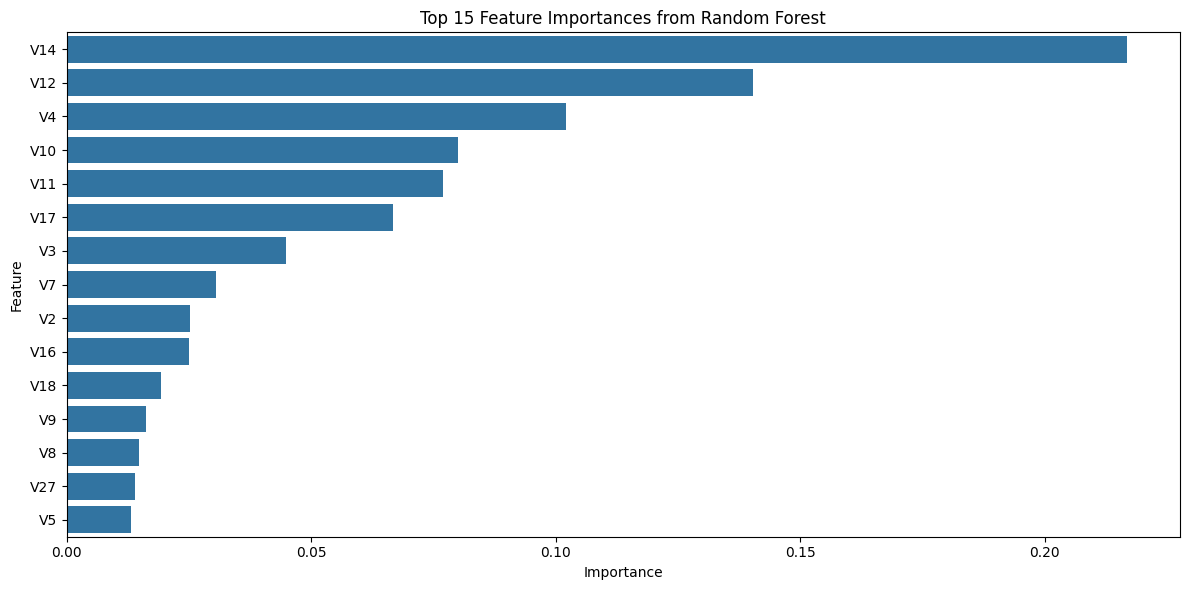

In [67]:
# === Feature Importance Plot === #
importances = clf.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature")
plt.title("Top 15 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()